In [118]:
# Update all relevant packages with conda
!conda install statsmodels seaborn pandas scipy seaborn numpy matplotlib -y 

Channels:
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/ezpz_env

  added / updated specs:
    - matplotlib
    - numpy
    - pandas
    - scipy
    - seaborn
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    patsy-0.5.6                |   py38hca03da5_0         291 KB
    statsmodels-0.14.0         |   py38hbda83bc_0        10.2 MB
    ------------------------------------------------------------
                                           Total:        10.5 MB

The following NEW packages will be INSTALLED:

  patsy              pkgs/main/osx-arm64::patsy-0.5.6-py38hca03da5_0 
  statsmodels        pkgs/main/osx-arm64::statsmodels-0.14.0-py38hbda83bc_0 



statsmodels-0.14.0   | 10.2 MB   |                                       |   0% 
statsmodels-0.14.0   | 10.2 MB   |                           

In [119]:
import sys
import pandas as pd
import numpy as np
import scipy.stats as ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [120]:
print(sys.executable)

/opt/anaconda3/envs/ezpz_env/bin/python


In [121]:
# List the contents of the current directory
!ls
# Print the working directory
!pwd
# Check the Python version
!python --version


ezpz_analysis.ipynb
/Users/ecrespo/Documents/github_project_folder/ezpzmouseanalytics/notebooks
Python 3.8.19


# Import the data

In [122]:
file_path = '/Users/ecrespo/Documents/github_project_folder/ezpzmouseanalytics/data/raw/Rbp4_social.csv' 

# Initialize the class 

In [123]:
class EzPzMouseAnalytics:
    def __init__(self, file_path):
        """
        Initialize the EzPzMouseAnalytics object with the path to the data file.
        Also, automatically create attributes for DataFrames separated by 'genotype'
        and by both 'genotype' and 'sex'.
        
        
        Explanation:
        DataFrame Grouping: Instead of using dictionaries, the groupby function is applied to create separate DataFrames for each genotype (self.genotype_groups) and for each combination of genotype and sex (self.genotype_sex_groups).
        Resetting Index: Each grouped DataFrame is reset to have a clean index after grouping. This makes it easier to work with these DataFrames independently.

        Data Storage:
        self.genotype_groups: Stores a single DataFrame where each group is separated by genotype.
        self.genotype_sex_groups: Stores a single DataFrame where each group is separated by both genotype and sex.
        
        # Access the genotype-separated DataFrame
        genotype_df = mouse_analysis.genotype_groups.loc['CTZ']

        # Access the genotype-sex-separated DataFrame
        genotype_sex_df = mouse_analysis.genotype_sex_groups.loc[('CTZ', 'M')]

        
        :param file_path: Path to the CSV file containing the data.
        """
        self.file_path = file_path
        self.data = None
        self.genotype_groups = None
        self.genotype_sex_groups = None
        self._initialize_dataframes()

    def _initialize_dataframes(self):
        """
        Internal method to initialize the genotype and genotype-sex separated DataFrames
        after loading the data.
        """
        self.extract_data()  # Load the data

        # Create separate DataFrames for each genotype
        self.genotype_groups = self.data.groupby('genotype').apply(lambda x: x.reset_index(drop=True))

        # Create separate DataFrames for each combination of genotype and sex
        self.genotype_sex_groups = self.data.groupby(['genotype', 'sex']).apply(lambda x: x.reset_index(drop=True))

    def extract_data(self):
        """
        Extract data from the CSV file and store it in a DataFrame.
        
        :return: DataFrame containing the loaded data.
        """
        self.data = pd.read_csv(self.file_path)
        return self.data

    def calculate_age_in_months(self):
        """
        Calculate the age of each mouse at the time of testing in months.
        
        :return: DataFrame with columns for DOB, datetested, and age in months.
        """
        if self.data is None:
            raise ValueError("Data not loaded. Please run extract_data() first.")
        
        # Clean up any leading or trailing spaces in the column names
        self.data.columns = self.data.columns.str.strip()
        
        # Rename 'date tested' to 'datetested' if it exists
        if 'date tested' in self.data.columns:
            self.data.rename(columns={'date tested': 'datetested'}, inplace=True)
        else:
            raise KeyError("Column 'date tested' not found in the data. Please check the column names.")
        
        # Convert DOB and datetested to datetime objects
        self.data['DOB'] = pd.to_datetime(self.data['DOB'], format='%m/%d/%y')
        self.data['datetested'] = pd.to_datetime(self.data['datetested'], format='%m/%d/%y')
        
        # Calculate the difference in months
        self.data['age_in_months'] = ((self.data['datetested'] - self.data['DOB']).dt.days / 30.44).round(2)
        return self.data[['DOB', 'datetested', 'age_in_months']]

    def check_unique_tags(self):
        """
        Ensure that the 'tag' column contains unique identifiers for each mouse.
        
        :return: DataFrame with duplicate tag entries if any exist; otherwise, None.
        """
        if self.data is None:
            raise ValueError("Data not loaded. Please run extract_data() first.")
        
        duplicate_tags = self.data[self.data.duplicated('tag', keep=False)]
        
        if not duplicate_tags.empty:
            return duplicate_tags[['tag', 'DOB', 'date tested', 'genotype', 'treatment']]
        else:
            print("All 'tag' values are unique.")
            return None

    def calculate_descriptive_stats(self, column_names, sex=None):
        """
        Calculate detailed descriptive statistics (N, mean, SD, range, CI, etc.) 
        for specified columns related to both Mouse 1 and Mouse 2 data.
        
        :param column_names: List of columns to compute statistics for.
        :param sex: Optional filter for the sex ('M' or 'F'). Default is None (no filter).
        
        :return: DataFrame containing the descriptive statistics.
        """
        if self.data is None:
            raise ValueError("Data not loaded. Please run extract_data() first.")
        
        # Apply sex filter if specified
        if sex is not None:
            filtered_data = self.data[self.data['sex'] == sex]
        else:
            filtered_data = self.data
        
        stats_data = {}
        
        for column in column_names:
            if column in filtered_data.columns:
                data = filtered_data[column].dropna()
                N = len(data)
                mean = data.mean()
                std = data.std()
                min_val = data.min()
                max_val = data.max()
                range_val = max_val - min_val
                ci = stats.t.interval(0.95, N-1, loc=mean, scale=std/np.sqrt(N)) if N > 1 else (None, None)
                
                stats_data[column] = {
                    'N': N,
                    'Mean': mean,
                    'SD': std,
                    'Min': min_val,
                    'Max': max_val,
                    'Range': range_val,
                    'CI Lower': ci[0],
                    'CI Upper': ci[1]
                }
            else:
                raise ValueError(f"Column '{column}' not found in the data.")
        
        return pd.DataFrame(stats_data).T
    
    def filter_by_sex(self, sex):
        """
        Filter the data by sex.
        
        :param sex: The sex to filter by (e.g., 'M' for male or 'F' for female).
        :return: DataFrame containing the filtered data.
        """
        if self.data is None:
            raise ValueError("Data not loaded. Please run extract_data() first.")
        
        self.filtered_data = self.data[self.data['sex'] == sex]
        return self.filtered_data

    def get_filtered_data(self):
        """
        Retrieve the filtered data.
        
        :return: DataFrame containing the filtered data.
        """
        if self.filtered_data is None:
            raise ValueError("No filtered data available. Please run a filter method first.")
        
        return self.filtered_data


class GenotypeComparisonAnalysis(EzPzMouseAnalytics):
    def __init__(self, file_path):
            """
            Initialize the GenotypeComparisonAnalysis object.
            
            :param file_path: Path to the CSV file containing the data.
            """
            super().__init__(file_path)
            self.genotype1 = 'Rbp4-LMO3'
            self.genotype2 = 'wt-LMO3'
            self.data_genotype1 = None
            self.data_genotype2 = None
            self._initialize_genotype_data()

    def _initialize_genotype_data(self):
            """
            Internal method to initialize the data for the two genotypes to be compared.
            """
            # Access the genotype-separated DataFrames
            if self.genotype1 in self.genotype_groups.index:
                self.data_genotype1 = self.genotype_groups.loc[self.genotype1]
            else:
                raise ValueError(f"Genotype '{self.genotype1}' not found in the data.")
            
            if self.genotype2 in self.genotype_groups.index:
                self.data_genotype2 = self.genotype_groups.loc[self.genotype2]
            else:
                raise ValueError(f"Genotype '{self.genotype2}' not found in the data.")

    def compare_multiple_metrics(self, metrics):
            """
            Compare multiple metrics between the two genotypes.
            
            :param metrics: List of metrics to compare (e.g., ['summouse1', 'summouse2']).
            :return: A dictionary of DataFrames with summary statistics for each metric.
            """
            summary_stats_dict = {}
            
            for metric in metrics:
                if metric not in self.data_genotype1.columns or metric not in self.data_genotype2.columns:
                    raise ValueError(f"Metric '{metric}' not found in the data.")
                
                data1 = self.data_genotype1[metric].dropna()
                data2 = self.data_genotype2[metric].dropna()
                
                # Perform t-test
                t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=False)
                
                # Compile summary statistics
                summary_stats = pd.DataFrame({
                    'Genotype': [self.genotype1, self.genotype2],
                    'N': [len(data1), len(data2)],
                    'Mean': [data1.mean(), data2.mean()],
                    'SD': [data1.std(), data2.std()],
                    'Min': [data1.min(), data2.min()],
                    'Max': [data1.max(), data2.max()],
                    'Range': [data1.max() - data1.min(), data2.max() - data2.min()],
                    'T-Statistic': [t_stat, t_stat],
                    'P-Value': [p_value, p_value]
                })
                
                summary_stats_dict[metric] = summary_stats
            
            return summary_stats_dict

    def plot_multiple_comparisons(self, metrics):
            """
            Generate boxplots comparing multiple metrics between the two genotypes.
            
            :param metrics: List of metrics to plot (e.g., ['summouse1', 'summouse2']).
            """
            num_metrics = len(metrics)
            fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 6))
            
            for i, metric in enumerate(metrics):
                if metric not in self.data_genotype1.columns or metric not in self.data_genotype2.columns:
                    raise ValueError(f"Metric '{metric}' not found in the data.")
                
                # Combine data for plotting
                plot_data = pd.concat([
                    self.data_genotype1[[metric]].assign(Genotype=self.genotype1),
                    self.data_genotype2[[metric]].assign(Genotype=self.genotype2)
                ])
                
                # Generate the boxplot
                sns.boxplot(x='Genotype', y=metric, data=plot_data, palette="Set2", ax=axes[i])
                sns.swarmplot(x='Genotype', y=metric, data=plot_data, color='black', alpha=0.75, ax=axes[i])
                axes[i].set_title(f'Comparison of {metric} between {self.genotype1} and {self.genotype2}')
                axes[i].set_xlabel('Genotype')
                axes[i].set_ylabel(metric)
            
            plt.tight_layout()
            plt.show()


In [124]:
# Initialize and process data
mouse_analysis = EzPzMouseAnalytics(file_path)
mouse_analysis.extract_data()
mouse_analysis.calculate_age_in_months()
mouse_analysis.check_unique_tags()

All 'tag' values are unique.


Summary statistics for summouse1:
     Genotype   N       Mean         SD  Min  Max  Range  T-Statistic   P-Value
0  Rbp4-LMO3  21  13.904762   9.380324    0   36     36    -2.436392  0.020312
1    wt-LMO3  23  24.434783  18.255326    2   74     72    -2.436392  0.020312
Summary statistics for summouse2:
     Genotype   N       Mean         SD  Min  Max  Range  T-Statistic  P-Value
0  Rbp4-LMO3  21  15.619048  11.324647    0   42     42    -2.435494  0.01961
1    wt-LMO3  23  26.173913  17.073776    5   65     60    -2.435494  0.01961


/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_1783/3596056993.py:254: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Genotype', y=metric, data=plot_data, palette="Set2", ax=axes[i])
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_1783/3596056993.py:254: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Genotype', y=metric, data=plot_data, palette="Set2", ax=axes[i])


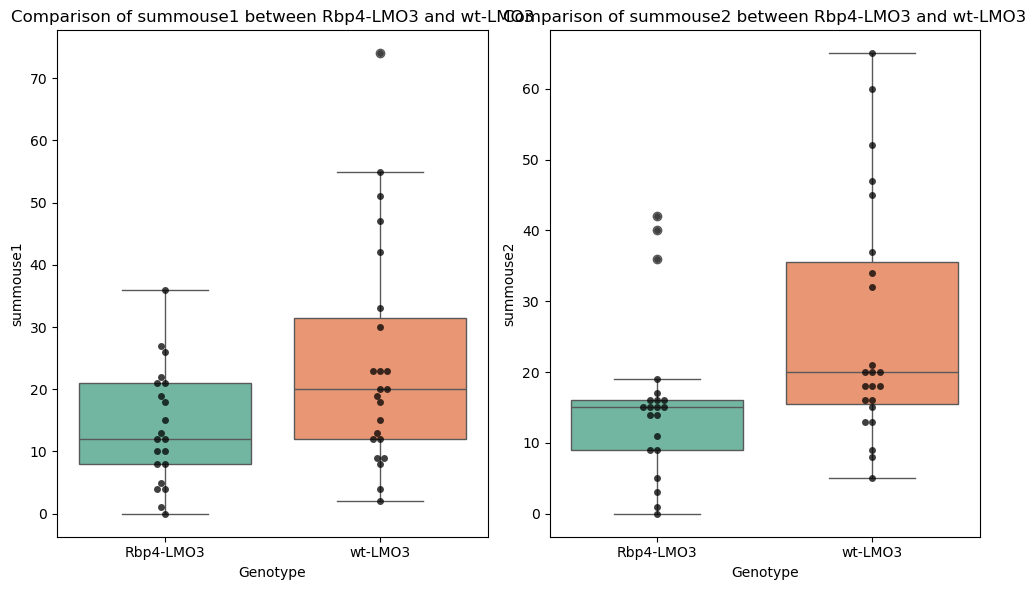

In [126]:
# Initialize the class with the path to your CSV file
analysis = GenotypeComparisonAnalysis(file_path)

# Compare multiple metrics between the genotypes
metrics = ['summouse1', 'summouse2']
summary_stats = analysis.compare_multiple_metrics(metrics)
for metric, stats_df in summary_stats.items():
    print(f"Summary statistics for {metric}:\n", stats_df)

# Plot the comparison for the same metrics
analysis.plot_multiple_comparisons(metrics)


In [139]:
summary_stats = analysis.compare_multiple_metrics(['summouse1', 'summouse2', 'avgmouse1', 'avgmouse2', 'boutmouse1', 'boutmouse2'])
for metric, stats_df in summary_stats.items():
    print(f"Summary statistics for {metric}:\n", stats_df)

Summary statistics for summouse1:
     Genotype   N       Mean         SD  Min  Max  Range  T-Statistic   P-Value
0  Rbp4-LMO3  21  13.904762   9.380324    0   36     36    -2.436392  0.020312
1    wt-LMO3  23  24.434783  18.255326    2   74     72    -2.436392  0.020312
Summary statistics for summouse2:
     Genotype   N       Mean         SD  Min  Max  Range  T-Statistic  P-Value
0  Rbp4-LMO3  21  15.619048  11.324647    0   42     42    -2.435494  0.01961
1    wt-LMO3  23  26.173913  17.073776    5   65     60    -2.435494  0.01961
Summary statistics for avgmouse1:
     Genotype   N      Mean        SD       Min        Max     Range  \
0  Rbp4-LMO3  21  2.342314  1.017753  0.000000   4.333333  4.333333   
1    wt-LMO3  23  3.694847  2.308479  1.857143  10.500000  8.642857   

   T-Statistic   P-Value  
0    -2.551388  0.015913  
1    -2.551388  0.015913  
Summary statistics for avgmouse2:
     Genotype   N      Mean        SD       Min  Max     Range  T-Statistic  \
0  Rbp4-LMO3  21

/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_1783/3596056993.py:254: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Genotype', y=metric, data=plot_data, palette="Set2", ax=axes[i])
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_1783/3596056993.py:254: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Genotype', y=metric, data=plot_data, palette="Set2", ax=axes[i])
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_1783/3596056993.py:254: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Genotype', y=metric, 

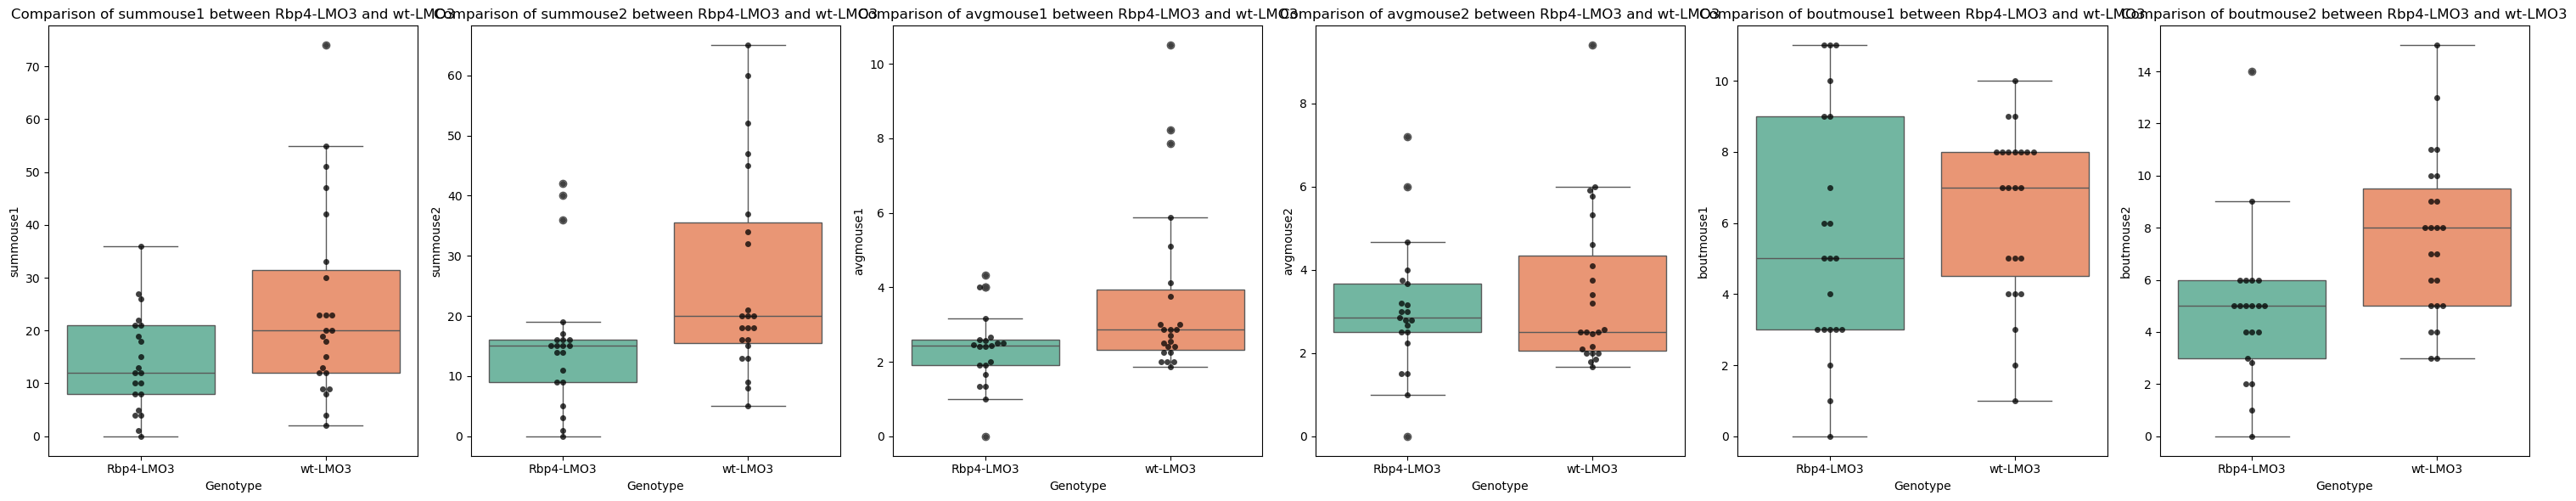

In [128]:
analysis.plot_multiple_comparisons(['summouse1', 'summouse2', 'avgmouse1', 'avgmouse2', 'boutmouse1', 'boutmouse2'])

In [151]:
for dv in ['summouse1', 'summouse2']:
    t_stat, p_value = stats.ttest_ind(analysis.data_genotype1[dv], analysis.data_genotype2[dv])
    print(f"Independent t-test for {dv}: t-stat={t_stat}, p-value={p_value}")


Independent t-test for summouse1: t-stat=-2.371287657015953, p-value=0.022388232474581563
Independent t-test for summouse2: t-stat=-2.3918203844738066, p-value=0.021319009408535542


In [152]:
data_long = pd.melt(analysis.data, id_vars=['genotype'], value_vars=['summouse1', 'summouse2'], 
                    var_name='interaction_type', value_name='interaction_time')
model = ols('interaction_time ~ C(genotype) * C(interaction_type)', data=data_long).fit()
anova_results = anova_lm(model)
print("ANOVA results:\n", anova_results)


ANOVA results:
                                    df        sum_sq      mean_sq         F  \
C(genotype)                       2.0   2525.598344  1262.799172  5.995165   
C(interaction_type)               1.0     96.043478    96.043478  0.455968   
C(genotype):C(interaction_type)   2.0     50.596273    25.298137  0.120103   
Residual                         86.0  18114.718427   210.636261       NaN   

                                   PR(>F)  
C(genotype)                      0.003652  
C(interaction_type)              0.501326  
C(genotype):C(interaction_type)  0.886977  
Residual                              NaN  


In [153]:
for genotype, data in analysis.genotype_groups.groupby('genotype'):
    correlation = data[['summouse1', 'summouse2']].corr().iloc[0, 1]
    print(f"Correlation between summouse1 and summouse2 for {genotype}: {correlation}")


ValueError: 'genotype' is both an index level and a column label, which is ambiguous.